In [1]:
import numpy as np
import pandas as pd

import io
import tifffile as tiff
import zipfile

import skimage.transform
import shapely.wkt # shapely.wkt.loads()
import shapely.geometry
import shapely.affinity
import cv2

from matplotlib import pyplot as plt

# Specify that this notebook should only use the CPU
# This avoids memory problems if the model is running on the GPU elsewhere
# Note: do not try to train / predict as this will likely be very slow
import os
os.environ["THEANO_FLAGS"] = "device=cpu,"

from keras.models import Model, load_model
from keras.layers import Input, merge, Activation, Convolution2D, MaxPooling2D, UpSampling2D, ZeroPadding2D, Cropping2D, BatchNormalization, Dropout
from keras.optimizers import Adam
from keras.callbacks import CSVLogger, ModelCheckpoint
from keras import backend as K
from keras.regularizers import l2
from keras.constraints import maxnorm
from keras.layers.advanced_activations import LeakyReLU
K.set_image_dim_ordering('th')  # Theano dimension ordering in this code
# "tf" assumes (rows, cols, channels) while "th" assumes (channels, rows, cols)
# Possibly change this around natively in the data so the backend doesn't have to switch them
# Only necessary if I use TF!

from matplotlib import pyplot as plt

from collections import defaultdict

from pushbullet import Pushbullet
def push(title='Done!',text=''):
    Pushbullet('o.YFPNNPfGRekivaCGHa4qMSgjZt8zJ6FL').devices[0].push_note(title,text)

Using TensorFlow backend.


In [2]:
sample = pd.read_csv('./data/kaggle-files/sample_submission.csv',names=['imageID','feature','wkt'],skiprows=1)
grid_sizes = pd.read_csv('./data/kaggle-files/grid_sizes.csv',names=['imageID','xmax','ymin'],skiprows=1)
weights_list = pd.read_csv('./data/kaggle-files/weights_list.csv',names=['run','class_','weights_file'],skiprows=1)
train_wkts = pd.read_csv('./data/kaggle-files/train_wkt_v4.csv',names=['imageID','feature','wkt'],skiprows=1)
class_ = 0

In [8]:
test_imgs = np.load('./data/submission-data/submission_images_136x136_processed.npy')[()]

# These are deprecated. Should rather make x/y from loading the train_images file
# As of 2017.02.05, that hasn't been augmented
#x = np.load('./data/x_augmented.npy','r')
#y = np.load('./data/y_augmented.npy','r')

In [4]:
# Compile the model. Take special note: the img sizes are hard coded here.

def compiler(img_rows = 136,img_cols = 136,
            nfilters = 32,activation = 'relu',init = 'he_normal',
            lr=1.0,decay=0.0,momentum=0.0, nesterov=False,reg=0.01,p=[0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2]):
    
    def jaccard(y_true, y_pred,smooth=1.):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return (intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + smooth)
    
    def Conv2DReluBatchNorm(n_filter, w_filter, h_filter, inputs, activation, init='he_uniform',dropout=0.2):
        # Batch norm after activation / leakyrelu
        #return BatchNormalization(mode=2, axis=1)(LeakyReLU()((Convolution2D(n_filter, w_filter, h_filter, border_mode='same',init=init,W_regularizer=l2(reg),W_constraint = maxnorm(3))(inputs))))
        
        # Batch norm before activation
        #return LeakyReLU()(BatchNormalization(mode=0, axis=1)((Convolution2D(n_filter, w_filter, h_filter, border_mode='same',init=init,W_regularizer=l2(reg),W_constraint = maxnorm(3))(inputs))))
        
        # Batch norm after activation / relu
        return BatchNormalization(mode=2, axis=1)(Activation(activation=activation)((Convolution2D(n_filter, w_filter, h_filter, border_mode='same',init=init,W_regularizer=l2(reg),W_constraint = maxnorm(3))(inputs))))
        
    def up_conv(nfilters,filter_factor,inputs,init=init,activation=activation):
        # No batch norm
        #return LeakyReLU()(Convolution2D(nfilters*filter_factor, 2, 2, border_mode='same',init=init,W_regularizer=l2(reg),W_constraint = maxnorm(3))(UpSampling2D(size=(2, 2))(inputs)))
        
        # Batch norm after activation
        #return BatchNormalization(mode=2, axis=1)(LeakyReLU()(Convolution2D(nfilters*filter_factor, 2, 2, border_mode='same',init=init,W_regularizer=l2(reg),W_constraint = maxnorm(3))(UpSampling2D(size=(2, 2))(inputs))))
        
        # Batch norm after activation / relu
        return BatchNormalization(mode=2, axis=1)(Activation(activation=activation)(Convolution2D(nfilters*filter_factor, 2, 2, border_mode='same',init=init,W_regularizer=l2(reg),W_constraint = maxnorm(3))(UpSampling2D(size=(2, 2))(inputs))))

    inputs = Input((20, img_rows, img_cols))
    padded = ZeroPadding2D(padding=(12,12))(inputs)
    
    conv1 = Conv2DReluBatchNorm(nfilters, 3, 3, padded, activation=activation,init=init)
    conv1 = Conv2DReluBatchNorm(nfilters, 3, 3, conv1, activation=activation,init=init)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    pool1 = Dropout(p=p[0])(pool1)

    conv2 = Conv2DReluBatchNorm(nfilters*2, 3, 3, pool1, activation=activation,init=init)
    conv2 = Conv2DReluBatchNorm(nfilters*2, 3, 3, conv2, activation=activation,init=init)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    pool2 = Dropout(p=p[1])(pool2)

    conv3 = Conv2DReluBatchNorm(nfilters*4, 3, 3, pool2, activation=activation,init=init)
    conv3 = Conv2DReluBatchNorm(nfilters*4, 3, 3, conv3, activation=activation,init=init)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    pool3 = Dropout(p=p[2])(pool3)

    conv4 = Conv2DReluBatchNorm(nfilters*8, 3, 3, pool3, activation=activation,init=init)
    conv4 = Conv2DReluBatchNorm(nfilters*8, 3, 3, conv4, activation=activation,init=init)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    pool4 = Dropout(p=p[3])(pool4)

    conv5 = Conv2DReluBatchNorm(nfilters*16, 3, 3, pool4, activation=activation,init=init)
    conv5 = Conv2DReluBatchNorm(nfilters*16, 3, 3, conv5, activation=activation,init=init)
    conv5 = Dropout(p=p[4])(conv5)
        
    up6 = merge([up_conv(nfilters,8,conv5), conv4], mode='concat', concat_axis=1)
    conv6 = Conv2DReluBatchNorm(nfilters*8, 3, 3, up6, activation=activation,init=init)
    conv6 = Conv2DReluBatchNorm(nfilters*8, 3, 3, conv6, activation=activation,init=init)
    conv6 = Dropout(p=p[5])(conv6)

    up7 = merge([up_conv(nfilters,4,conv6), conv3], mode='concat', concat_axis=1)
    conv7 = Conv2DReluBatchNorm(nfilters*4, 3, 3, up7, activation=activation,init=init)
    conv7 = Conv2DReluBatchNorm(nfilters*4, 3, 3, conv7, activation=activation,init=init)
    conv7 = Dropout(p=p[6])(conv7)

    up8 = merge([up_conv(nfilters,2,conv7), conv2], mode='concat', concat_axis=1)
    conv8 = Conv2DReluBatchNorm(nfilters*2, 3, 3, up8, activation=activation,init=init)
    conv8 = Conv2DReluBatchNorm(nfilters*2, 3, 3, conv8, activation=activation,init=init)
    conv8 = Dropout(p=p[7])(conv8)

    up9 = merge([up_conv(nfilters,1,conv8), conv1], mode='concat', concat_axis=1)
    conv9 = Conv2DReluBatchNorm(nfilters, 3, 3, up9, activation=activation,init=init)
    conv9 = Conv2DReluBatchNorm(nfilters, 3, 3, conv9, activation=activation,init=init)
    conv9 = Dropout(p=p[8])(conv9)
    
    conv10 = Conv2DReluBatchNorm(1, 1, 1, conv9, activation='relu',init=init)
    cropped = Cropping2D(cropping=((12,12), (12,12)))(conv10)
    output = Activation(activation='sigmoid')(cropped)
    
    model = Model(input=inputs, output=output)
    
    model.compile(optimizer=Adam(lr=lr,decay=decay), loss='binary_crossentropy', metrics=[jaccard])
    
    return model

p=[0.1,0.2,0.3,0.4,0.5,0.4,0.3,0.2,0.1] # current version
#p=[0.2,0.3,0.4,0.5,0.5,0.5,0.4,0.3,0.2] # symmetric but more dropout
#p=[0.2,0.2,0.3,0.3,0.4,0.4,0.5,0.5,0.6] # increasing

In [5]:
def jaccard_np(y_true,y_pred,smooth=1):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) - intersection + smooth)

In [6]:
model = compiler(img_rows=136,img_cols=136,
            nfilters=16,activation='relu',init='he_normal',
            lr=0.001,decay=0,momentum=0,reg=0,p=p)

In [ ]:
# Predict on images from train set
# Threshold at a range of values
# Measure jaccard index at each threshold
# Do not run this repeatedly. Rather run once on a new set of weights then load the thresholds 
# from the ./data/misc/chosen_thresholds.npy file


thresholds = {}

for i,row in weights_list.iterrows():
    y_oneclass = y[:,row[1]:row[1]+1,...]
    i = np.random.choice(400,60,replace=False)
    model.load_weights('./data/weights/model_weights_class_{}_run_{}.hdf5'.format(row[1],row[0]))
    print('Predicting now on class {}'.format(row[1]))
    predictions = model.predict(x[i,...],batch_size=20,verbose=1)
    msks = y_oneclass[i,...]
    thresholds[row[1]] = {}
    for threshold in np.linspace(0,1,11):
        pred = predictions.copy()
        pred[pred>=threshold] = 1
        pred[pred<threshold] = 0
        thresholds[row[1]][threshold] = jaccard_np(msks,pred)

In [ ]:
# This script picks out the maximum threshold from the dict and save that into a new dict (and onto disk!)

chosen_thresh = {}
for class_ in thresholds.keys():
    class_scores = thresholds[class_]
    max_threshold = max(class_scores, key=lambda key: class_scores[key])
    print('Best threshold for class {} is {}, with a jacard index of {}'.format(class_,round(max_threshold,2),thresholds[class_][max_threshold]))
    chosen_thresh[int(class_,)] = round(max_threshold,1)
np.save('./data/misc/chosen_thresholds.npy',chosen_thresh)

#### The functions to make polygons from masks!

In [70]:
def make_polygons(msk, epsilon=5, min_area=1.):
    # first, find contours with cv2: it's much faster than shapely
    # cv2.RETR_CCOMP specifies that there are only two hierarchies: external and internal
    contours, hierarchy = cv2.findContours(((msk == 1) * 255).astype(np.uint8), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_TC89_KCOS)[1:]
    # contours, hierarchy = cv2.findContours(msk.astype(np.uint8), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_TC89_KCOS)[1:]
    
    # create approximate contours to have reasonable submission size
    approx_contours = [cv2.approxPolyDP(cnt, epsilon, True) for cnt in contours]
    
    if not contours:
        return shapely.geometry.MultiPolygon()
    
    # now messy stuff to associate parent and child contours
    # defaultdict creates an emptylist if it's called on a key that doesn't exist
    cnt_children = defaultdict(list)
    
    # Creates an empty set, which is an unordered collection
    child_contours = set()
    
    # Tests if hierarchy has shape 1 in the first dimension
    # Should throw an error if it is not 1, i.e. we expect it to be 1
    assert hierarchy.shape[0] == 1
    
    # http://docs.opencv.org/3.1.0/d9/d8b/tutorial_py_contours_hierarchy.html
    # The hierarchy is an array of (4,) elements like this: [Next, Previous, First_Child, Parent]
    # Hierarchy should have shape (1, X, 4) thus hierarchy[0] just grabs the all of hierarchy arrays
    # We then grab the Parents value and the contour's position (from enumerate) for each contour
    for idx, parent_idx in enumerate(hierarchy[0][:,3]):
        # If the parent_id != -1, this means there is a parent, thus this hiearchy is a child
        if parent_idx != -1:
            # Add the id of that contour to the child contours set
            child_contours.add(idx)
            # Add a key:value to the cnt_children dict, 
            # The key is the contour id, and the value is a list containing the child contour
            #cnt_children[parent_idx].append(approx_contours[idx])
            cnt_children[parent_idx].append(contours[idx])
    
    # Ultimately, the child polygons must be filled with 0 so that they are empty...
    # Thus have a dict of child contours (with their corresponding parent ID) is helpful
    
    # create actual polygons filtering by area (removes artifacts)
    all_polygons = []
    # For each contour...
    #for idx, cnt in enumerate(approx_contours):
    for idx, cnt in enumerate(contours):
        # First check that the contour is not a child
        # And determine that it's area is larger than some minimum we can define
        # min_area is set to 1 for now
        if idx not in child_contours and cv2.contourArea(cnt) >= min_area:
            # Check that the second dimension of the contour is 1
            assert cnt.shape[1] == 1
            
            # Make a shapely polygon object
            # supply shell and holes
            # Shells are the contours that passed the if test above (i.e. NOT children)
            # Holes are all of the children that are stored in the cnt_children dict
            # The list comprehension grabs each contour from the dict matching the ID of this polygon and checks it's size is above the minimum
            poly = shapely.geometry.Polygon(shell=cnt[:, 0, :],
                                            holes=[c[:, 0, :] for c in cnt_children.get(idx, []) if cv2.contourArea(c) >= min_area])
            
            # Finally, we append this polygon to the running list
            all_polygons.append(poly)
            
    # approximating polygons might have created invalid ones, fix them
    all_polygons = shapely.geometry.MultiPolygon(all_polygons)
    
    # The is_valid() method from shapely returns true if the polygon is valid
    if not all_polygons.is_valid:
        # From http://toblerity.org/shapely/shapely.geometry.html#module-shapely.geometry.multipolygon
        # A zero distance may be used to “tidy” a polygon
        all_polygons = all_polygons.buffer(0)
        
        # Sometimes buffer() converts a simple Multipolygon to just a Polygon,
        # need to keep it a Multi throughout
        if all_polygons.type == 'Polygon':
            all_polygons = shapely.geometry.MultiPolygon([all_polygons])
    return all_polygons

#### Generating submissions!

In [ ]:
# This is written for the submission images

wkts = {}
msks = {}
def predictor(class_, run):
    threshold = chosen_thresh[class_]
    
    predict = True
    if os.path.exists('./data/submission-data/submisison_msks.npy'):
        msks = np.load('./data/submission-data/submisison_msks.npy')[()]
        predict = False
        
    model.load_weights('./data/weights/model_weights_class_{}_run_{}.hdf5'.format(class_, run))
    for imageID in sorted(sample.imageID.unique()):
        # Check to see if the imageID has been added to msks dict before, if not add it as an empty dict
        if imageID not in msks:
            msks[imageID] = {}
        # Same check as above but for imageID in wkts dict   
        if imageID not in wkts:
            wkts[imageID] = {}
            
        # Get the img and predict
        img = test_imgs[imageID]
        if predict:
            msk = model.predict(img[np.newaxis,...])
            msks[imageID][class_] = msk
        
        if not predict:
            msk = msks[imageID][class_]

        # Threshold the mask
        msk = msk >= threshold
        #msk[msk < threshold] = 0

        # Make polygons
        polygons = make_polygons(msk.reshape((136,136)))

        # Scale polygons
        # Double check this...
        img_h, img_w = img.shape[1], img.shape[2]
        xmax, ymin = grid_sizes[grid_sizes.imageID == imageID].iloc[0, 1:].astype(float)
        xfact = xmax / (img_w * (img_w / (img_w + 1)))
        yfact = ymin / (img_h * (img_h / (img_h + 1)))

        polygons = shapely.affinity.scale(polygons, xfact=xfact, yfact=yfact, origin=(0, 0, 0))

        # Make WKTs
        wkt = shapely.wkt.dumps(polygons)
        wkts[imageID][class_] = wkt
    print('Class {} done'.format(class_))

for i,row in weights_list.iterrows():
    predictor(row[1],row[0])
    
np.save('./data/submission-data/submisison_wkts.npy',wkts)
np.save('./data/submission-data/submisison_msks.npy',msks)
push('The submissions have been predicted on...','')

In [139]:
submission_csv = pd.DataFrame(columns=('ImageId', 'ClassType', 'MultipolygonWKT'))
for i,row in sample.iterrows():
    if wkts[row[0]][row[1]-1] == "GEOMETRYCOLLECTION EMPTY":
        submission_csv.loc[i] = [row[0],row[1],"MULTIPOLYGON EMPTY"]
    else:
        submission_csv.loc[i] = [row[0],row[1],wkts[row[0]][row[1]-1]]
submission_csv.ClassType = submission_csv.ClassType.apply(np.int8)
submission_csv.to_csv('./data/submissions/submission.gz',index=False,compression='gzip')

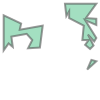

In [106]:
shapely.wkt.loads(wkts['6120_2_4'][1])

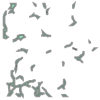

In [143]:
shapely.wkt.loads(wkts['6130_1_0'][3])

### Contour approximation
Epsilon needs to be set carefully.

Potential strategy:
1. Predict on training images for each class
2. Calculate jaccard for each epsilon
3. Perhaps choose a different epsilon for each class?
3. Choose the best epsilon

## Experimenting with making jaccards from preds of the original training data

In [12]:
train_imgs = np.load('./data/training-data/train_images_136x136_processed.npy')[()]

In [ ]:
wkts = {}
msks = {}
def predictor(class_, run):
    threshold = chosen_thresh[class_]
    
    predict = True
    #if os.path.exists('./data/submisison_msks.npy'):
    #    msks = np.load('./data/submisison_msks.npy')[()]
    #    predict = False
        
    model.load_weights('./data/weights/model_weights_class_{}_run_{}.hdf5'.format(class_, run))
    for imageID in sorted(train_wkts.imageID.unique()):
        # Check to see if the imageID has been added to msks dict before, if not add it as an empty dict
        if imageID not in msks:
            msks[imageID] = {}
        # Same check as above but for imageID in wkts dict   
        if imageID not in wkts:
            wkts[imageID] = {}
            
        # Get the img and predict
        img = train_imgs[imageID]
        if predict:
            msk = model.predict(img[np.newaxis,...])
            msks[imageID][class_] = msk
        
        if not predict:
            msk = msks[imageID][class_]

        # Threshold the mask
        msk = msk >= threshold
        #msk[msk < 0.5] = 0

        # Make polygons
        polygons = make_polygons(msk.reshape((136,136)),min_area=1e-3)

        # Scale polygons
        # Double check this...
        img_h, img_w = img.shape[1], img.shape[2]
        xmax, ymin = grid_sizes[grid_sizes.imageID == imageID].iloc[0, 1:].astype(float)
        xfact = xmax / (img_w * (img_w / (img_w + 1)))
        yfact = ymin / (img_h * (img_h / (img_h + 1)))

        polygons = shapely.affinity.scale(polygons, xfact=xfact, yfact=yfact, origin=(0, 0, 0))

        # Make WKTs
        wkt = shapely.wkt.dumps(polygons)
        wkts[imageID][class_] = wkt
    print('Class {} done'.format(class_))

for i,row in weights_list.iterrows():
    predictor(row[1],row[0])
    
#np.save('./data/submisison_wkts.npy',wkts)
#np.save('./data/submisison_msks.npy',msks)

In [ ]:
# Calculate the jaccard indices of the training predictions

jaccards = {}
for imageID in train_wkts.imageID.unique():
    jaccards[imageID] = {}
    for class_ in range(1,11):
        pred_polygon = shapely.wkt.loads(wkts[imageID][class_-1])
        #pred_polygon = shapely.wkt.loads(train_wkts[(train_wkts.imageID == imageID)&(train_wkts.feature == class_)].wkt.values[0])
        true_polygon = shapely.wkt.loads(train_wkts[(train_wkts.imageID == imageID)&(train_wkts.feature == class_)].wkt.values[0])
        #print(pred_polygon)
        if not pred_polygon.is_empty or not true_polygon.is_empty:
            intersection = pred_polygon.intersection(true_polygon).area
            union = pred_polygon.union(true_polygon).area
            
            jaccards[imageID][class_] = intersection / (union + 1e-8)
        else:
            pass
            #jaccards[imageID][class_] = 'No polygon'

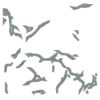

In [85]:
shapely.wkt.loads(wkts['6150_2_3'][3])

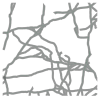

In [86]:
shapely.wkt.loads(train_wkts[(train_wkts.imageID == '6150_2_3')&(train_wkts.feature == 4)].wkt.values[0])